In [4]:
import torch
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Download the CIFAR-10 dataset and preprocess it. Here, you can find an example of how to do so using
PyTorch. Keep in mind that the transformation in the example is just for demonstration purposes. You
should add more transformations as part of the preprocessing step such as normalization.

In [5]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Download the training and test datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


Find the size of the train and test datasets. Then, find the shape of the images. Finally, print the different classes of the dataset.

In [6]:
# Sizes of the train and test datasets
train_size = len(train_dataset)
test_size = len(test_dataset)

# Shape of one image
example_image, example_label = train_dataset[0]  # Get the first image and label
image_shape = example_image.shape  # This will be in (C, H, W) format

# Classes in the CIFAR-10 dataset
classes = train_dataset.classes  # Get the list of classes

# Print results
print(f"Training dataset size: {train_size}")
print(f"Test dataset size: {test_size}")
print(f"Shape of one image: {image_shape}")
print(f"Classes in the dataset: {classes}")


Training dataset size: 50000
Test dataset size: 10000
Shape of one image: torch.Size([3, 32, 32])
Classes in the dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Visualize 2 or 3 random images and their class labels from the training and testing datasets, respectively.

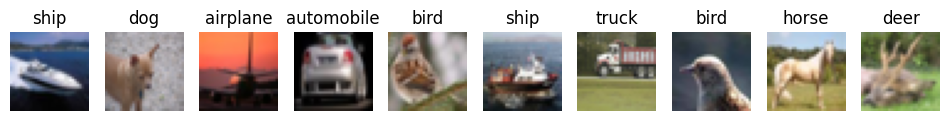

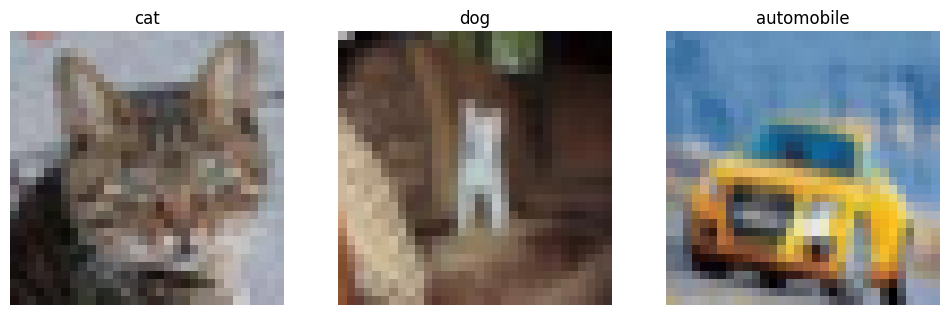

In [17]:
def visualize_random_images(dataset, num_images=3):
    # Select random indices
    random_indices = random.sample(range(len(dataset)), num_images)

    # Set up the plot
    plt.figure(figsize=(12, 4))

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C) for plotting
        
        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image / 2 + 0.5)  # Unnormalize image for visualization
        plt.title(dataset.classes[label])  # Class label
        plt.axis('off')

    plt.show()

# Visualize random images from training dataset
visualize_random_images(train_dataset, 10)

# Visualize random images from testing dataset
visualize_random_images(test_dataset)


 Split the training dataset into training and validation sets.

In [8]:
# Define the size of the validation set
validation_size = int(0.2 * len(train_dataset))  # 20% for validation
training_size = len(train_dataset) - validation_size  # Remaining 80% for training

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [training_size, validation_size])

# Print the sizes of the new subsets
print(f"Training subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")


Training subset size: 40000
Validation subset size: 10000


Use data loaders for the three datasets.

In [9]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the sizes of the DataLoaders
print(f"Training DataLoader size: {len(train_loader)} batches")
print(f"Validation DataLoader size: {len(val_loader)} batches")
print(f"Test DataLoader size: {len(test_loader)} batches")


Training DataLoader size: 1250 batches
Validation DataLoader size: 313 batches
Test DataLoader size: 313 batches


Implement your convolutional neural network class to classify CIFAR-10 data using nn.Module.

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 32 filters
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # 64 filters
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # After pooling, size is 64 * 8 * 8
        self.fc2 = nn.Linear(512, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.conv1(x))  # First conv layer with ReLU
        x = F.max_pool2d(x, 2)  # Max pooling
        
        x = F.relu(self.conv2(x))  # Second conv layer with ReLU
        x = F.max_pool2d(x, 2)  # Max pooling
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))  # First fully connected layer
        x = self.fc2(x)  # Second fully connected layer (output layer)
        
        return x

# Instantiate the model
model = CNN()
print(model)


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


 When you are ready to train the network (refer to the Appendix in page 3), change the runtime type to
a GPU to speed up the training. (Tip: start with 2 epochs to make sure everything works before you
3
increase the number of epochs). Then, plot the training and validation losses with respect to the epoch
numbers.


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# Move model to the GPU
model = CNN().to(device)


In [ ]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # No gradients needed for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Calculate average validation loss
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [1/10], Training Loss: 1.2928, Validation Loss: 0.9933
Epoch [2/10], Training Loss: 0.8956, Validation Loss: 0.8659
Epoch [3/10], Training Loss: 0.6815, Validation Loss: 0.8203
Epoch [4/10], Training Loss: 0.4827, Validation Loss: 0.8357
Epoch [5/10], Training Loss: 0.3007, Validation Loss: 0.9711
Epoch [6/10], Training Loss: 0.1765, Validation Loss: 1.2005
Epoch [7/10], Training Loss: 0.1135, Validation Loss: 1.3344


Test your CNN using the test data. Report the accuracy of your CNN classification overall and per-class

In [13]:
# Set the model to evaluation mode
model.eval()  
correct = 0
total = 0
class_correct = [0] * 10  # Assuming there are 10 classes
class_total = [0] * 10

with torch.no_grad():  # No gradients needed for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes

        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Correct predictions

        # Count correct predictions for each class
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

# Overall accuracy
overall_accuracy = 100 * correct / total

# Per-class accuracy
per_class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(10)]

# Print results
print(f'Overall Test Accuracy: {overall_accuracy:.2f}%')
for i in range(10):
    print(f'Accuracy for class {i}: {per_class_accuracy[i]:.2f}%')


Overall Test Accuracy: 68.53%
Accuracy for class 0: 72.50%
Accuracy for class 1: 77.80%
Accuracy for class 2: 43.60%
Accuracy for class 3: 55.40%
Accuracy for class 4: 55.50%
Accuracy for class 5: 69.50%
Accuracy for class 6: 80.10%
Accuracy for class 7: 70.20%
Accuracy for class 8: 84.10%
Accuracy for class 9: 76.60%


Make a new CNN class that is a copy of your original CNN. Then add a convolutional layer to the new
network architecture. Train the new network, the same way you did with the first network (same
hyperparameters, optimizer and number of epochs ...) and compare the accuracy results (overall and perclass) with the old network

In [14]:
class NewCNN(nn.Module):
    def __init__(self):
        super(NewCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # New layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Update input size based on pooling
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv3(x))  # Forward through new layer
        x = F.max_pool2d(x, 2)  # Add pooling after the new layer
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Instantiate the new model
new_model = NewCNN().to(device)


In [15]:
# Hyperparameters
num_epochs = 2  # Use 2 for testing, increase later if needed
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses_new = []
val_losses_new = []

# Training loop for the new model
for epoch in range(num_epochs):
    new_model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        # Forward pass
        outputs = new_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses_new.append(avg_train_loss)

    # Validation phase
    new_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # No gradients needed for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU

            outputs = new_model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    # Calculate average validation loss
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses_new.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [1/2], Training Loss: 1.3656, Validation Loss: 1.0748
Epoch [2/2], Training Loss: 0.9295, Validation Loss: 0.8767


In [16]:
# Evaluate the new model
new_model.eval()  
correct_new = 0
total_new = 0
class_correct_new = [0] * 10  # Assuming there are 10 classes
class_total_new = [0] * 10

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        # Forward pass
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_new += labels.size(0)
        correct_new += (predicted == labels).sum().item()

        # Count correct predictions for each class
        for i in range(len(labels)):
            label = labels[i]
            class_correct_new[label] += (predicted[i] == label).item()
            class_total_new[label] += 1

# Overall accuracy
overall_accuracy_new = 100 * correct_new / total_new

# Per-class accuracy
per_class_accuracy_new = [100 * class_correct_new[i] / class_total_new[i] if class_total_new[i] > 0 else 0 for i in range(10)]

# Print results
print(f'Overall Test Accuracy for New CNN: {overall_accuracy_new:.2f}%')
for i in range(10):
    print(f'Accuracy for class {i} (New CNN): {per_class_accuracy_new[i]:.2f}%')


Overall Test Accuracy for New CNN: 68.15%
Accuracy for class 0 (New CNN): 62.10%
Accuracy for class 1 (New CNN): 81.50%
Accuracy for class 2 (New CNN): 49.00%
Accuracy for class 3 (New CNN): 48.40%
Accuracy for class 4 (New CNN): 56.70%
Accuracy for class 5 (New CNN): 74.50%
Accuracy for class 6 (New CNN): 73.60%
Accuracy for class 7 (New CNN): 75.00%
Accuracy for class 8 (New CNN): 85.70%
Accuracy for class 9 (New CNN): 75.00%
